# Figure 1C - YARN Normalization Version

A `heatplot` representing similarity in the fold-changes between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues. </b>

We downloaded the GTEx version 8.0 RNA-seq and genotype data (phs000424.v8.v2), released 2019-08-26.
We used YARN (https://bioconductor.org/packages/release/bioc/html/yarn.html), uploading the downloadGTEx function
to download this release, and used it to perform quality control, gene filtering and normalization pre-processing on the
GTEx RNA-seq data, as described in (Paulson et al, 2017).   This pipelines tested for sample sex-misidentification, 
merged related sub-tissues, performed tissue-aware normalization using qsmooth (Hicks et al, 2017).

## Loading dependencies

In [137]:
library(downloader)
library(readr)
library(edgeR)
library(biomaRt)
library(DBI) # v >= 1.1.0 required for biomaRt
library(devtools)
library(yarn)
library(statmod)
library(piggyback)
library(snakecase)
Sys.setenv(TAR = "/bin/tar") # for gzfile

Begin here if you have already run this and created the `data/gtex.rds` file

Please `git clone` the repository and start working after changing to this as your working directory (`cd lifebitCloudOSDRE`). The `data` subdirectory, along with all other paths used in this Notebook are relative to the `lifebitCloudOSDRE` repository.

In [ ]:
#NOTE TO USERS:
#
# Either run option 1 or option 2
#
# 1. CAUTION! It requires some minutes to complete, also memory and enough storage
#

# Load with readRDS() if gtex.rds available in data/
if ("gtex.rds" %in% list.files("../data/")) {
    message("Loading GTEx v8 rds object with readRDS from /data/gtex.rds ..\n")    
    obj <- readRDS(file = "../data/gtex.rds" )
    message("Done!")    
}

# Download if not available in ../data
if (!("gtex.rds" %in% list.files("../data/"))) {
    message("Downloading GTEx v8 with 'yarn::downloadGTExV8()'")
    obj <- yarn::downloadGTExV8(type='genes',file='../data/gtex.rds')
    message("Done!")    

}

#
# or
#
# 2. Retrieve the released location the already generated gtex.rds
# 
#    Run the following line in the data directory prior to the next line if you wish to use the already
#    generated file.
# 
#    and then run this line.
#   
#    To Run option 2 -- launch a terminal window 
#    and change to the 'data' subdirectory
#
#    cd lifebitCloudOSDRE/data
#
#    and run this command
#
#    wget https://github.com/lifebit-ai/lifebitCloudOSDREgtex/releases/download/gtex_archive/gtex.rds
#  
#    Then come back to this R code and uncomment this line.
#
#    obj <- readRDS("../data/gtex.rds")

Parsed with column specification:
cols(
  .default = col_double(),
  SAMPID = col_character(),
  SMCENTER = col_character(),
  SMPTHNTS = col_character(),
  SMTS = col_character(),
  SMTSD = col_character(),
  SMUBRID = col_character(),
  SMNABTCH = col_character(),
  SMNABTCHT = col_character(),
  SMNABTCHD = col_character(),
  SMGEBTCH = col_character(),
  SMGEBTCHD = col_character(),
  SMGEBTCHT = col_character(),
  SMAFRZE = col_character(),
  SMGTC = col_logical(),
  SMNUMGPS = col_logical(),
  SM550NRM = col_logical(),
  SM350NRM = col_logical(),
  SMMNCPB = col_logical(),
  SMMNCV = col_logical(),
  SMCGLGTH = col_logical()
  # ... with 2 more columns
)
See spec(...) for full column specifications.
Warning message:
“379 parsing failures.
  row   col           expected            actual                                       file
14837 SMGTC 1/0/T/F/TRUE/FALSE 6293764057_R01C01 '/tmp/RtmpSZvYDF/phenodat56491469a517.txt'
14838 SMGTC 1/0/T/F/TRUE/FALSE 7983311048_R05C02 '/tmp/RtmpSZ

In [ ]:
# Confirm that it is an expression set.
# and check the dimensions of the objects, and the phenotype information of the objects
class(obj) 
dim(phenoData(obj))
dim(obj)

In [4]:
#Okay - for some reason our phenotype data is larger than our expression data - I've written Joe Paulson about that.
#In the meantime, make sure that the two sets are aligned.
sample_names=as.vector(as.character(colnames(exprs(obj))))
head(sample_names)
length(sample_names)

pheno_sample_names=as.vector(as.character(rownames(pData(obj))))
head(pheno_sample_names)
length(pheno_sample_names)

logical_match_names=pheno_sample_names %in% sample_names
length(logical_match_names)
table(logical_match_names)
pData(obj) <- (pData(obj)[logical_match_names==TRUE,])
dim(pData(obj))
dim(obj)

[1] "GTEX-1117F-0226-SM-5GZZ7" "GTEX-1117F-0426-SM-5EGHI"
[3] "GTEX-1117F-0526-SM-5EGHJ" "GTEX-1117F-0626-SM-5N9CS"
[5] "GTEX-1117F-0726-SM-5GIEN" "GTEX-1117F-1326-SM-5EGHH"

[1] 17382

[1] "GTEX-1117F-0226-SM-5GZZ7" "GTEX-1117F-0426-SM-5EGHI"
[3] "GTEX-1117F-0526-SM-5EGHJ" "GTEX-1117F-0626-SM-5N9CS"
[5] "GTEX-1117F-0726-SM-5GIEN" "GTEX-1117F-1326-SM-5EGHH"

[1] 17384

[1] 17384

logical_match_names
FALSE  TRUE 
    2 17382 

[1] 17382    67

Features  Samples 
   55878    17382

In [5]:
#  Now we want to replace all *dashes* with _underscores_

In [6]:
newSampID <- gsub('-','\\.',pData(obj)$SAMPID)

In [7]:
head (newSampID)

[1] "GTEX.1117F.0226.SM.5GZZ7" "GTEX.1117F.0426.SM.5EGHI"
[3] "GTEX.1117F.0526.SM.5EGHJ" "GTEX.1117F.0626.SM.5N9CS"
[5] "GTEX.1117F.0726.SM.5GIEN" "GTEX.1117F.1326.SM.5EGHH"

In [8]:
pData(obj)$SAMPID <- newSampID

In [9]:
colnames(pData(obj))

[1] "SAMPID"    "SMATSSCR"  "SMCENTER"  "SMPTHNTS"  "SMRIN"     "SMTS"     
 [7] "SMTSD"     "SMUBRID"   "SMTSISCH"  "SMTSPAX"   "SMNABTCH"  "SMNABTCHT"
[13] "SMNABTCHD" "SMGEBTCH"  "SMGEBTCHD" "SMGEBTCHT" "SMAFRZE"   "SMGTC"    
[19] "SME2MPRT"  "SMCHMPRS"  "SMNTRART"  "SMNUMGPS"  "SMMAPRT"   "SMEXNCRT" 
[25] "SM550NRM"  "SMGNSDTC"  "SMUNMPRT"  "SM350NRM"  "SMRDLGTH"  "SMMNCPB"  
[31] "SME1MMRT"  "SMSFLGTH"  "SMESTLBS"  "SMMPPD"    "SMNTERRT"  "SMRRNANM" 
[37] "SMRDTTL"   "SMVQCFL"   "SMMNCV"    "SMTRSCPT"  "SMMPPDPR"  "SMCGLGTH" 
[43] "SMGAPPCT"  "SMUNPDRD"  "SMNTRNRT"  "SMMPUNRT"  "SMEXPEFF"  "SMMPPDUN" 
[49] "SME2MMRT"  "SME2ANTI"  "SMALTALG"  "SME2SNSE"  "SMMFLGTH"  "SME1ANTI" 
[55] "SMSPLTRD"  "SMBSMMRT"  "SME1SNSE"  "SME1PCTS"  "SMRRNART"  "SME1MPRT" 
[61] "SMNUM5CD"  "SMDPMPRT"  "SME2PCTS"  "SUBJID"    "SEX"       "AGE"      
[67] "DTHHRDY"

In [10]:
head(exprs(obj))

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2526-SM-5GZY6,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-2926-SM-5GZYI,⋯,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1426-SM-5GZZ6,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
ENSG00000223972.5,0,0,0,0,0,0,0,0,0,0,⋯,0,2,0,0,0,0,0,0,1,1
ENSG00000227232.5,187,109,143,251,113,139,199,473,286,306,⋯,72,96,136,79,89,86,49,84,34,66
ENSG00000278267.1,0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000243485.5,1,0,0,1,0,0,0,0,0,1,⋯,0,0,1,0,2,2,0,1,0,0
ENSG00000237613.2,0,0,0,0,0,0,0,1,0,0,⋯,1,0,0,0,0,0,0,0,0,0
ENSG00000268020.3,0,1,0,0,0,1,1,0,1,2,⋯,1,0,0,1,2,0,0,0,1,1


In [11]:
#  Now let us do the differential analysis - using EdgeR

In [12]:
x <- exprs(obj)

In [13]:
dim(x)

[1] 55878 17382

In [14]:
# To use the DGEList function from EdgeR, we need to transpose our x so that the length of group is equal
# to the number of columns in our counts (x).
# You will get an error in DGEList (counts = x, group = group) if the length of group is not equal to the number of columns in counts

In [15]:
group <- factor(pData(obj)$SEX)

In [16]:
table(group)

group
    1     2 
11584  5798 

In [17]:
#caution this step takes a lot of memory and time - so do one of two things again:
#
# 1. You can either run this step from scratch and save the rds object for next time.
#
#y <- DGEList(counts=x, group=group)
#y <- calcNormFactors(y)
#saveRDS(y, file = "../data/DGENormFactorsy.rds")
#
# 2. or if you have already run this step and want to retrieve it again
# you can read this from the saved rds object
#

# Load with readRDS() if `../data/DGENormFactorsy.rds` available in data/
if ("DGENormFactorsy.rds" %in% list.files("../data/")) {
    message("Loading  `../data/DGENormFactorsy.rds` object with `readRDS()` from ../data/ \n")    
    y <- readRDS("../data/DGENormFactorsy.rds")
    message("Done!")    
}


# Download if not available in ../data
if (!("DGENormFactorsy.rds" %in% list.files("../data/"))) {
    message("Creating `DGEList` object from counts matrix with 'edgeR::DGEList()' ..")
    y <- edgeR::DGEList(counts=x, group=group)
    message("Done!\n")    

    message("Calculating normalization factors on `DGEList` object to scale the raw library sizes with 'edgeR::DGEList()' ..")    
    y <- edgeR::calcNormFactors(y)
    message("Done!\n")    

    message("Saving normalization factors object in '../data/DGENormFactorsy.rds' ..")        
    saveRDS(y, file = "../data/DGENormFactorsy.rds")
    message("Done!\n")    
}


attributes(y)

Loading  `../data/DGENormFactorsy.rds` object with `readRDS()` from ../data/ 

Done!


$class
[1] "DGEList"
attr(,"package")
[1] "edgeR"

$names
[1] "counts"  "samples"

In [18]:
dim(y$counts)

[1] 55878 17382

In [19]:
# For Guy -- does this do what you are expecting -- I am confused because what you get when you
#        ask for the min (table(groups)) is the smaller sized group -- which in this case is 
#        female -- it will help the reader to know what you are doing here with the statement.
#        one can read what it is doing but not understand your objective.groups <- pData(obj)$SEX
# keep.events <- rep(TRUE, nrow(y))
#for (group in c(1,2)) {
#    keep.events <- keep.events & 
#                   rowSums(cpm(y[,groups %in% group]) > 1) >= 0.25*min(table(groups))
#}
#
#  From Anne - I believe the objective in this step is to keep only those genes that are in the
#    that are above the threshold of expression for the lower quartile of all sex specific genes.
#    groups = (1,2) -- lots of confusion in logic between groups and group and male and female
#    I recommend we use male and female.
#    two errors then in the above loop - 
#     1. min(table(groups)) will always return the
#        length of the number of samples that are female 
#        (which is 5978 for this v8 GTEx)
#     2. sum(table(group)) will return the number of samples that are either male or female
#        depending upon whether you are in the loop for male or female consideration.
#
#    If my assumption is true - I recommend replacing it with the following.
#
#  this should be relaced 
#
keep.events <- rep(TRUE, nrow(y))
nrow(y)
table(pData(obj)$SEX)
table(group)
#
# first keep all the events for the male subsets meeting our threshold criteria
#
keep.events  <- keep.events & rowSums(cpm(y$counts[,group == 1]) > 1) >= 0.25*length(group==1)
#
# now keep all the male subsets or the female subsets meeting our criteria
#
keep.events2 <- keep.events | rowSums(cpm(y$counts[,group == 2]) > 1) >= 0.25*length(group==2)
table(keep.events)
table(keep.events2)

[1] 55878


    1     2 
11584  5798 

group
    1     2 
11584  5798 

keep.events
FALSE  TRUE 
39984 15894 

keep.events2
FALSE  TRUE 
39983 15895 

In [20]:

# Load with readRDS() if `../data/reduced_y.rds` available in data/
if  ( ('reduced_y.rds' %in% list.files("../data/")) && ('reduced_obj' %in% list.files("../data/"))) {
    message("Loading  `reduced_y.rds` and  `reduced_obj` objects with `readRDS()` from ../data/ \n")    
    reduced_obj <- readRDS(file = "../data/reduced_obj.rds")
    reduced_y   <- readRDS(file = "../data/reduced_y.rds")
    message("Done!")    
}


# Create if not available in ../data
if  ( !(('reduced_y.rds' %in% list.files("../data/")) && ('reduced_obj' %in% list.files("../data/")))) {

    message("Creating `reduced_y` keeping only rows that match `keep.events2` list ..")
    reduced_y<- y[keep.events2,]
    message("Done!\n")    
    
    message("Creating `reduced_obj` keeping only rows that match `keep.events2` list ..")    
    reduced_obj <- obj[keep.events2==TRUE,]
    message("Done!\n")    
    
    message("Saving `reduced_y.rds`, `reduced_obj.rds` in '../data/' ..")        
    saveRDS(reduced_y, file = "../data/reduced_y.rds")
    saveRDS(reduced_obj, file = "../data/reduced_obj.rds")
    message("Done!\n")     
}

dim(reduced_obj)

Creating `reduced_y` keeping only rows that match `keep.events2` list ..
Done!

Creating `reduced_obj` keeping only rows that match `keep.events2` list ..
Done!

Saving `reduced_y.rds`, `reduced_obj.rds` in '../data/' ..
Done!



Features  Samples 
   15895    17382

In [21]:
# separate the analysis by male and by female

In [22]:
reduced_male   <- pData(reduced_obj)$SEX==1
reduced_female <- pData(reduced_obj)$SEX==2

In [23]:
reduced_obj_male   <- reduced_obj[,reduced_male==TRUE]
reduced_obj_female <- reduced_obj[,reduced_female==TRUE]

In [24]:
dim(reduced_obj_male)
dim(reduced_obj_female)

Features  Samples 
   15895    11584

Features  Samples 
   15895     5798

In [25]:
# changing from SMTS to SMTSD - more granularity -- but we could produce both figures
tissue_groups_male <- factor(pData(reduced_obj_male)$SMTSD)
tissue_groups_female <- factor(pData(reduced_obj_female)$SMTSD)

In [26]:
# good sanity check, the male set does not have any vaginas or uterus
table (tissue_groups_male)

tissue_groups_male
                   Adipose - Subcutaneous 
                                      445 
             Adipose - Visceral (Omentum) 
                                      371 
                            Adrenal Gland 
                                      157 
                           Artery - Aorta 
                                      279 
                        Artery - Coronary 
                                      146 
                          Artery - Tibial 
                                      454 
                                  Bladder 
                                       14 
                         Brain - Amygdala 
                                      107 
 Brain - Anterior cingulate cortex (BA24) 
                                      128 
          Brain - Caudate (basal ganglia) 
                                      183 
            Brain - Cerebellar Hemisphere 
                                      157 
                       Brain - Cere

In [27]:
# and the females have no prostate or testis
table(tissue_groups_female)

tissue_groups_female
                   Adipose - Subcutaneous 
                                      218 
             Adipose - Visceral (Omentum) 
                                      170 
                            Adrenal Gland 
                                      101 
                           Artery - Aorta 
                                      153 
                        Artery - Coronary 
                                       94 
                          Artery - Tibial 
                                      209 
                                  Bladder 
                                        7 
                         Brain - Amygdala 
                                       45 
 Brain - Anterior cingulate cortex (BA24) 
                                       48 
          Brain - Caudate (basal ganglia) 
                                       63 
            Brain - Cerebellar Hemisphere 
                                       58 
                       Brain - Ce

In [28]:
# Reproducing Guys results using the yarn expression object
# loop through the tissues and for those tissues that are shared between the two sexes
# perform a differential gene analysis on a per tissue basis


In [29]:
tissue_groups <- factor(pData(reduced_obj)$SMTSD)

In [30]:
tissue_male_female <- tissue_groups_male %in% tissue_groups_female
table(tissue_male_female)

tissue_male_female
FALSE  TRUE 
  606 10978 

In [31]:
tissue_shared_male_female <- factor(tissue_groups_male[tissue_male_female])
table(tissue_shared_male_female)

tissue_shared_male_female
                   Adipose - Subcutaneous 
                                      445 
             Adipose - Visceral (Omentum) 
                                      371 
                            Adrenal Gland 
                                      157 
                           Artery - Aorta 
                                      279 
                        Artery - Coronary 
                                      146 
                          Artery - Tibial 
                                      454 
                                  Bladder 
                                       14 
                         Brain - Amygdala 
                                      107 
 Brain - Anterior cingulate cortex (BA24) 
                                      128 
          Brain - Caudate (basal ganglia) 
                                      183 
            Brain - Cerebellar Hemisphere 
                                      157 
                       Brain

In [32]:
# SEX is coded 1 == Male
#              2 == Female
sex = factor(pData(reduced_obj)$SEX)

In [33]:
library(stringr)

In [34]:
#
# define a function that takes two inputs, the tissue and an object
#    and createe teh model matrix based upon that tissue's sex
#    perform a linear fit after calculating normal factors (based upon library size)
#    and calculate the dispersion using voom (mean variance model of dispersion)
#    grab the results - save the results for prosperity and make a variable
#
fit_tissue <- function (tissue, obj) {
    tissue_true   <- pData(obj)$SMTSD == tissue
    tissue_obj    <- obj[,tissue_true ==TRUE]
    tissue_sex    <- factor(pData(tissue_obj)$SEX)
    tissue_design <- model.matrix(~tissue_sex)
    y_tissue      <- DGEList(counts=exprs(tissue_obj), group=tissue_sex)
    y_tissue      <- calcNormFactors(y_tissue)
    y_tissue_voom <- voom(y_tissue, tissue_design)
    fit_tissue    <- lmFit(y_tissue_voom, tissue_design)
    fit_tissue    <- eBayes(fit_tissue, robust=TRUE)
    results_tissue <- topTable (fit_tissue, coef='tissue_sex2', number=nrow(y_tissue))
    filename       <-  paste(paste("../data/", 
                           tissue),
                     "DGE.txt", 
                     sep="_")
    
    write.table(results_tissue, filename, sep='\t', quote=FALSE)
    return (results_tissue)
}

In [35]:
# debugging with using the 'Thyroid' tissue
#thyroid_logFC <- fit_tissue('Thyroid',reduced_obj)
#thyroid_logFC
# 
all_logFC <- lapply(X=levels(tissue_shared_male_female), FUN=fit_tissue, obj=reduced_obj)

In [95]:
filenames <- list.files("../data", pattern="*_DGE.txt", all.files=FALSE, full.names=FALSE)
(filenames)

[1] "Adipose - Subcutaneous_DGE.txt"                   
 [2] "Adipose - Visceral (Omentum)_DGE.txt"             
 [3] "Adrenal Gland_DGE.txt"                            
 [4] "Artery - Aorta_DGE.txt"                           
 [5] "Artery - Coronary_DGE.txt"                        
 [6] "Artery - Tibial_DGE.txt"                          
 [7] "Bladder_DGE.txt"                                  
 [8] "Brain - Amygdala_DGE.txt"                         
 [9] "Brain - Anterior cingulate cortex (BA24)_DGE.txt" 
[10] "Brain - Caudate (basal ganglia)_DGE.txt"          
[11] "Brain - Cerebellar Hemisphere_DGE.txt"            
[12] "Brain - Cerebellum_DGE.txt"                       
[13] "Brain - Cortex_DGE.txt"                           
[14] "Brain - Frontal Cortex (BA9)_DGE.txt"             
[15] "Brain - Hippocampus_DGE.txt"                      
[16] "Brain - Hypothalamus_DGE.txt"                     
[17] "Brain - Nucleus accumbens (basal ganglia)_DGE.txt"
[18] "Brain - Putamen (basal ganglia)_DGE.txt"          
[19] "Brain - Spinal cord (cervical c-1)_DGE.txt"       
[20] "Brain - Substantia nigra_DGE.txt"                 
[21] "Breast - Mammary Tissue_DGE.txt"                  
[22] "Cells - Cultured fibroblasts_DGE.txt"             
[23] "Cells - EBV-transformed lymphocytes_DGE.txt"      
[24] "Colon - Sigmoid_DGE.txt"                          
[25] "Colon - Transverse_DGE.txt"                       
[26] "Esophagus - Gastroesophageal Junction_DGE.txt"    
[27] "Esophagus - Mucosa_DGE.txt"                       
[28] "Esophagus - Muscularis_DGE.txt"                   
[29] "Heart - Atrial Appendage_DGE.txt"                 
[30] "Heart - Left Ventricle_DGE.txt"                   
[31] "Kidney - Cortex_DGE.txt"                          
[32] "Kidney - Medulla_DGE.txt"                         
[33] "Liver_DGE.txt"                                    
[34] "Lung_DGE.txt"                                     
[35] "Minor Salivary Gland_DGE.txt"                     
[36] "Muscle - Skeletal_DGE.txt"                        
[37] "Nerve - Tibial_DGE.txt"                           
[38] "Pancreas_DGE.txt"                                 
[39] "Pituitary_DGE.txt"                                
[40] "Skin - Not Sun Exposed (Suprapubic)_DGE.txt"      
[41] "Skin - Sun Exposed (Lower leg)_DGE.txt"           
[42] "Small Intestine - Terminal Ileum_DGE.txt"         
[43] "Spleen_DGE.txt"                                   
[44] "Stomach_DGE.txt"                                  
[45] "Thyroid_DGE.txt"                                  
[46] "Whole Blood_DGE.txt"

In [37]:
# preserve the ordered rownames for later assignment to matrix
fullfilename <- paste('../data',filenames[1],sep="/")
logFC_mat <- read.delim2(fullfilename, stringsAsFactors=FALSE)
logFC_mat <- logFC_mat[order(rownames(logFC_mat)),]
logFC_mat_rownames <- as.character(rownames(logFC_mat)) 

In [38]:
# Make a matrix for each of the tissues
# from what files are saved

make_tissue_matrix_ready <- function (file, obj) {
    filename        <- paste('../data',file,sep="/")
    logFC_mat       <- read.delim2(filename, stringsAsFactors = FALSE)
    logFC_mat       <- logFC_mat[order(rownames(logFC_mat)),]
    logFC           <- as.matrix(as.numeric(logFC_mat$logFC),nrow=dim(obj)[2],ncol=1)
    rownames(logFC) <- rownames(logFC_mat)
    return(logFC)
}

In [39]:
matrix_list <- lapply(X=filenames, FUN=make_tissue_matrix_ready, obj=reduced_obj)

In [96]:
length(matrix_list)
logFC_mat = as.matrix(lapply(X   = matrix_list, 
                             FUN = cbind),
                      nrow = dim(reduced_obj)[2], 
                      ncol = length(matrix_list))
length(logFC_mat)

[1] 46

[1] 46

In [97]:
get_tissue_name <- function (tissue_name) {
            tissue <- str_replace(tissue_name,'_DGE.txt','')
            return(tissue)
}

In [98]:
tissue_list <- lapply(X=levels(tissue_shared_male_female), FUN=get_tissue_name)
length(tissue_list)
head(tissue_list)

[1] 46

[[1]]
[1] "Adipose - Subcutaneous"

[[2]]
[1] "Adipose - Visceral (Omentum)"

[[3]]
[1] "Adrenal Gland"

[[4]]
[1] "Artery - Aorta"

[[5]]
[1] "Artery - Coronary"

[[6]]
[1] "Artery - Tibial"

In [99]:
logFC_mat = as.matrix(as.numeric(unlist(matrix_list[1]),nrow=dim(reduced_obj)[2], ncol=1))

for (i in (2:length(matrix_list))) {
    n = as.matrix(as.numeric(unlist(matrix_list[i]),nrow=dim(reduced_obj)[2], ncol=1))
    logFC_mat = cbind(logFC_mat, n)
}

dim(logFC_mat)
rownames(logFC_mat) = logFC_mat_rownames
colnames(logFC_mat) = tissue_list
head(logFC_mat)

[1] 15895    46

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),⋯,Nerve - Tibial,Pancreas,Pituitary,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Thyroid,Whole Blood
ENSG00000000003.14,0.159867956,-0.054390442,-0.001420062,0.01910579,0.055831994,0.01975686,0.03369222,0.037372370,-0.05653552,0.01459946,⋯,-0.003767259,0.076920723,-0.29786285,-0.057271529,0.07130993,0.152350904,-0.014153064,0.043080117,-0.083539471,0.14002859
ENSG00000000419.12,-0.015111798,0.054725155,0.029764670,0.01092628,0.036753966,0.01059017,-0.04660812,-0.001611315,0.02301793,0.06902469,⋯,-0.001930505,-0.022461103,-0.05328584,0.005487066,0.05605845,-0.007142621,0.005660932,-0.055294508,-0.012258786,0.14732442
ENSG00000000457.13,0.009501953,0.001604707,-0.044547080,0.02654465,0.001420152,0.07241408,0.01623332,0.069141796,0.06588816,0.03153251,⋯,-0.016295587,-0.008384726,0.04280993,-0.035631149,-0.06907719,0.022458670,0.031778550,-0.007238725,0.023054013,0.18745209
ENSG00000000460.16,-0.036024716,0.016972717,0.015813767,0.04380547,-0.030048709,0.03885698,-0.07443956,0.036740174,0.06604508,-0.01706688,⋯,-0.015547288,0.017757642,0.06010527,0.012014626,-0.04743994,0.056236812,0.075831554,-0.017456828,0.053498280,0.01243589
ENSG00000000938.12,0.371970973,0.133928403,-0.178667703,0.11281414,-0.005249730,0.02795555,0.23602905,0.194845873,0.20882122,0.33196655,⋯,0.178659024,-0.309908157,0.03900437,0.256315471,0.33101095,-0.008547992,-0.114185714,0.032198632,0.152990274,0.06422003
ENSG00000000971.15,0.101369591,-0.052725628,0.215478378,0.01473135,-0.118761119,-0.08043895,-0.15960934,0.286809636,0.12973142,0.25777970,⋯,0.032645652,-0.174701746,0.02503865,0.247245406,0.28298039,-0.365205249,-0.004167090,0.033286928,0.007787418,-0.19620740


In [100]:
logFC_mat_NQ <- normalizeQuantiles(logFC_mat)

In [101]:
head(logFC_mat_NQ)

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),⋯,Nerve - Tibial,Pancreas,Pituitary,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Thyroid,Whole Blood
ENSG00000000003.14,0.18163856,-0.057699749,-0.002561785,0.03100612,0.0671783351,0.02962109,0.02421133,0.0414066450,-0.07948192,0.009461349,⋯,-0.007560889,0.12859512,-0.20844639,-0.068721403,0.09323422,0.16301173,-0.016072268,0.071045424,-0.124524045,0.109587317
ENSG00000000419.12,-0.01290889,0.072514519,0.036283839,0.01793584,0.0416967915,0.01572716,-0.02702430,-0.0005564463,0.02096841,0.081626002,⋯,-0.003155334,-0.03289401,-0.05493662,0.003479065,0.07420289,-0.01129464,0.009315197,-0.096737082,-0.021242066,0.116820740
ENSG00000000457.13,0.01753074,0.007059282,-0.054765500,0.04220573,0.0003125237,0.12100082,0.01288429,0.0755805325,0.07373944,0.032011415,⋯,-0.036807183,-0.01040080,0.05439554,-0.044553550,-0.09598508,0.02152593,0.041177680,-0.009562226,0.029252925,0.159291298
ENSG00000000460.16,-0.03704866,0.025192776,0.018491241,0.06727793,-0.0331672748,0.05999445,-0.04329810,0.0408642805,0.07391683,-0.028678481,⋯,-0.035249020,0.03213168,0.07909456,0.010959443,-0.06915861,0.05783887,0.099170937,-0.027087795,0.070267301,0.002878269
ENSG00000000938.12,0.40449005,0.183163005,-0.234672498,0.14864390,-0.0067902018,0.04212011,0.15156786,0.2121257423,0.26199942,0.413599973,⋯,0.344435114,-0.37680111,0.04905316,0.311078523,0.37250988,-0.01303658,-0.146072512,0.054242144,0.186963834,0.042745248
ENSG00000000971.15,0.12194223,-0.056092042,0.243680747,0.02400421,-0.1206659800,-0.09712891,-0.09392522,0.3355878654,0.15231143,0.306434374,⋯,0.075144397,-0.22330161,0.03107249,0.300366927,0.32556092,-0.40784357,-0.003512847,0.055919787,0.008558994,-0.216267208


In [47]:
dist_mat <- as.matrix(cor(logFC_mat_NQ))

In [48]:
head(dist_mat)

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),⋯,Nerve - Tibial,Pancreas,Pituitary,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Thyroid,Whole Blood
Adipose - Subcutaneous,1.0000000,0.8365272,0.7440858,0.8033718,0.7970331,0.8053699,0.8231428,0.7739447,0.7843509,0.7867614,⋯,0.8650933,0.7583434,0.7764261,0.8086684,0.8132758,0.8384233,0.7820020,0.8116124,0.8479777,0.7859629
Adipose - Visceral (Omentum),0.8365272,1.0000000,0.7807381,0.7840836,0.8462510,0.8220345,0.8159421,0.7563617,0.7623832,0.7814339,⋯,0.8200249,0.7763044,0.7703798,0.8054233,0.8102348,0.8240124,0.7958134,0.7946560,0.8242039,0.7790460
Adrenal Gland,0.7440858,0.7807381,1.0000000,0.8007187,0.8291998,0.7873730,0.7711136,0.7459315,0.7454137,0.7447619,⋯,0.7647180,0.8304141,0.7528460,0.7532003,0.7575763,0.7812392,0.8224205,0.7992741,0.7598380,0.7694753
Artery - Aorta,0.8033718,0.7840836,0.8007187,1.0000000,0.8620546,0.8465083,0.7943843,0.7737738,0.7845717,0.7753456,⋯,0.8113718,0.7865932,0.7611948,0.7810575,0.7804755,0.7861684,0.7920763,0.8156777,0.8001367,0.7968146
Artery - Coronary,0.7970331,0.8462510,0.8291998,0.8620546,1.0000000,0.8724207,0.7847650,0.7530278,0.7585706,0.7692536,⋯,0.7987615,0.8127769,0.7682309,0.8066411,0.8146596,0.8146890,0.8147805,0.8007671,0.7817212,0.8061614
Artery - Tibial,0.8053699,0.8220345,0.7873730,0.8465083,0.8724207,1.0000000,0.7852306,0.7644496,0.7636510,0.7685798,⋯,0.8512421,0.8203590,0.7970638,0.8221117,0.8230303,0.8054339,0.7998696,0.8230236,0.8059742,0.7988171


In [58]:
rownames(dist_mat) <- colnames(logFC_mat)
colnames(dist_mat) <- colnames(logFC_mat)

message("Saving dist_mat object")
saveRDS(object = dist_mat, file = "../data/dist_mat.rds")
message("Done!")

Saving dist_mat object
Done!


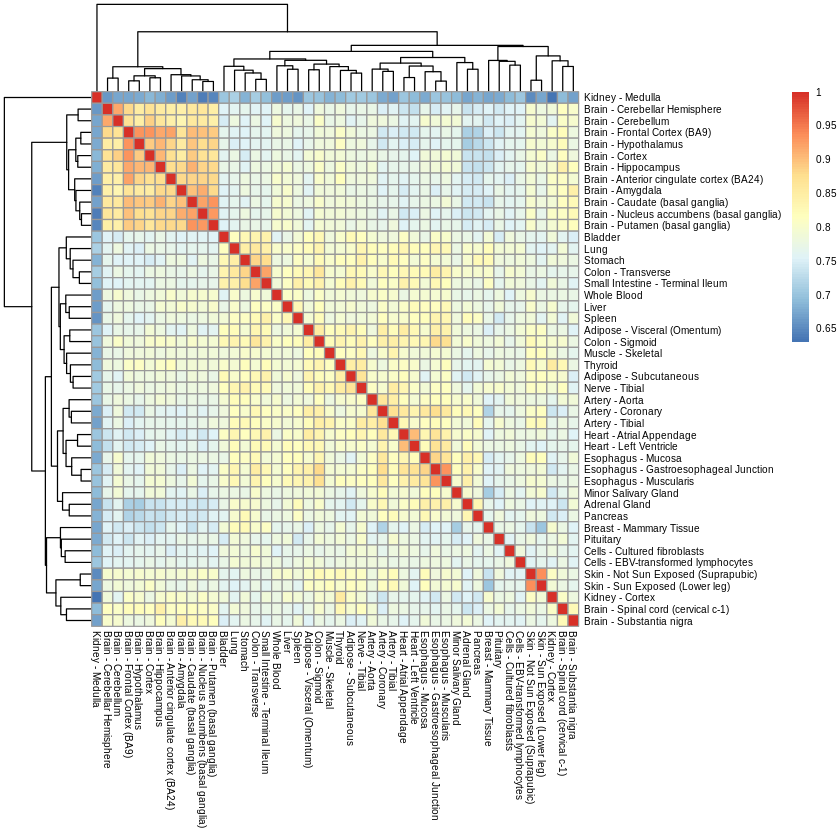

In [50]:
library(pheatmap)
pheatmap(as.matrix(dist_mat),   fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/Figure1c.pdf"))

## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [132]:
message("Generating sha256 checksums of teh artefacts in the `..data/` directory .. ")
system("cd ../data/ && sha256sum * > ../metadata/sha256sums.txt", intern = TRUE)
message("Done!\n")


Generating sha256 checksums of teh artefacts in the `..data/` directory .. 


character(0)

Done!



### 2. Libraries metadata

In [136]:
session_info <- devtools::session_info()
message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(session_info, file = "../metadata/devtools_session_info.rds")
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(session_info, file = "../metadata/utils_info.rds")
message("Done!\n")

session_info$platform

session_info$packages

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..
Done!

Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..
Done!



 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.2 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-02-21                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
annotate,annotate,1.64.0,1.64.0,/opt/conda/lib/R/library/annotate,/opt/conda/lib/R/library/annotate,FALSE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
AnnotationDbi,AnnotationDbi,1.48.0,1.48.0,/opt/conda/lib/R/library/AnnotationDbi,/opt/conda/lib/R/library/AnnotationDbi,FALSE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
askpass,askpass,1.1,1.1,/opt/conda/lib/R/library/askpass,/opt/conda/lib/R/library/askpass,FALSE,FALSE,2019-01-13,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
assertthat,assertthat,0.2.1,0.2.1,/opt/conda/lib/R/library/assertthat,/opt/conda/lib/R/library/assertthat,FALSE,FALSE,2019-03-21,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
backports,backports,1.1.5,1.1.5,/opt/conda/lib/R/library/backports,/opt/conda/lib/R/library/backports,FALSE,FALSE,2019-10-02,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
base64,base64,2.0,2.0,/opt/conda/lib/R/library/base64,/opt/conda/lib/R/library/base64,FALSE,FALSE,2016-05-10,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
base64enc,base64enc,0.1.3,0.1-3,/opt/conda/lib/R/library/base64enc,/opt/conda/lib/R/library/base64enc,FALSE,FALSE,2015-07-28,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
beanplot,beanplot,1.2,1.2,/opt/conda/lib/R/library/beanplot,/opt/conda/lib/R/library/beanplot,FALSE,FALSE,2014-09-19,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
Biobase,Biobase,2.46.0,2.46.0,/opt/conda/lib/R/library/Biobase,/opt/conda/lib/R/library/Biobase,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library


## Creating artefacts archives with **[`{ropensci::piggyback}`](https://github.com/ropensci/piggyback)**